In [13]:
import pandas
import numpy
from matplotlib import pyplot
%matplotlib inline

### IO: Reading and preprocess the data

We can define a function which will read the data and process them.

In [4]:
def read_spectra(path_csv):
    s = pandas.read_csv(path_csv)
    c = s['concentration']
    m = s['molecule']
    s = s['spectra']
    x = []
    for spec in s:
        x.append(numpy.fromstring(spec[1:-1], sep=','))
    s = pandas.DataFrame(x)
    
    return s, c, m

In [8]:
f = pandas.read_csv('data/freq.csv')

filenames = ['data/spectra_{}.csv'.format(i)
             for i in range(4)]

stot = []
c = []
m = []
for filename in filenames:
    s_tmp, c_tmp, m_tmp = read_spectra(filename)
    stot.append(s_tmp)
    c.append(c_tmp)
    m.append(m_tmp)

stot = pandas.concat(stot)
c = pandas.concat(c)
m = pandas.concat(m)

### Plot helper functions

We can create two functions: (i) to plot all spectra and (ii) plot the mean spectra with the std intervals.
We will make a "private" function which will be used by both plot types.

In [50]:
def _apply_axis_layout(ax, title):
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Concentration')
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

def plot_spectra(f, s, title):
    fig, ax = pyplot.subplots()
    ax.plot(f, s.T)
    _apply_axis_layout(ax, title)
    
def plot_spectra_by_type(f, s, classes, title):
    fig, ax = pyplot.subplots()
    for c_type in numpy.unique(classes):
        i = numpy.nonzero(classes == c_type)[0]
        ax.plot(f, numpy.mean(stot.iloc[i], axis=0), label=c_type)
        ax.fill_between(numpy.ravel(f), numpy.mean(s.iloc[i], axis=0) + numpy.std(s.iloc[i], axis=0), numpy.mean(s.iloc[i], axis=0) - numpy.std(s.iloc[i], axis=0), alpha=0.2)
    _apply_axis_layout(ax, title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

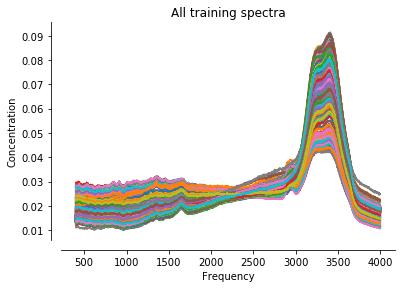

In [43]:
plot_spectra(f, stot, 'All training spectra')

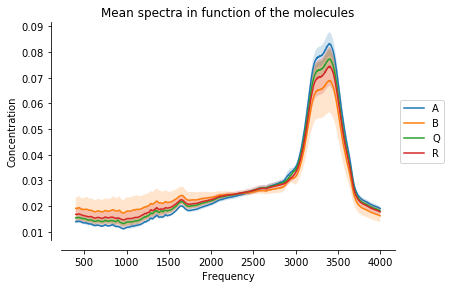

In [44]:
plot_spectra_by_type(f, stot, m, 'Mean spectra in function of the molecules')

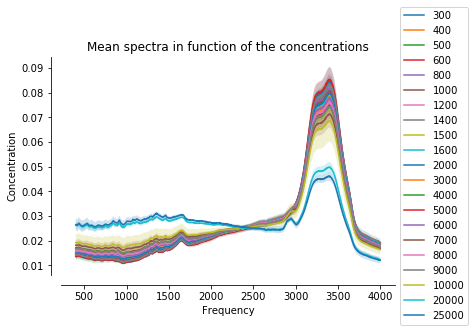

In [45]:
plot_spectra_by_type(f, stot, c, 'Mean spectra in function of the concentrations')

### Reusability for new data:

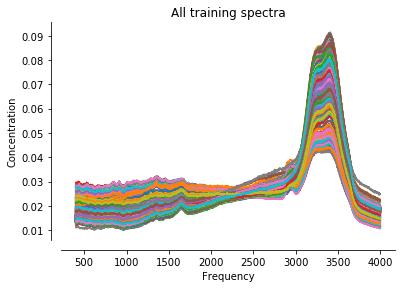

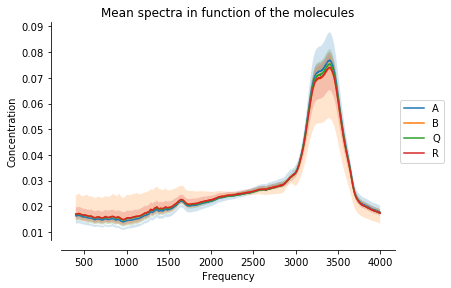

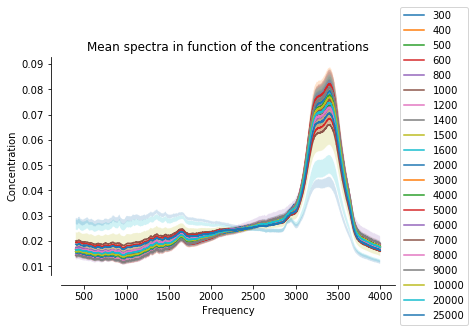

In [49]:
s4, c4, m4 = read_spectra('data/spectra_4.csv')

plot_spectra(f, stot, 'All training spectra')
plot_spectra_by_type(f, s4, m4, 'Mean spectra in function of the molecules')
plot_spectra_by_type(f, s4, c4, 'Mean spectra in function of the concentrations')